In [2]:
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [3]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
plt.rcParams['savefig.facecolor']='white'
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [4]:
# vid names as saved in behavioral data
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", 
            "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]

In [5]:
#loading shen atlas labels
pd.set_option('display.max_colwidth', None) # so columns are not snipped
# loading the Shen atlas labels
shen268_lbl = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268_lbl.head()
# to print an ROI: eval(shen268[str(insert ROI val between 1-268)][0])['name']

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


In [6]:
# load responses (nsubs * nmovies, values 0 for "no", 1 for "yes", "9" for unsure )
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses[0,:]

array([nan,  0.,  1., nan, nan,  1.,  1.,  0.,  1.,  9.])

In [7]:
l_task = 28

In [8]:
tr0_ind = 3 # ind at which tr=0 starts
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
tr_compensate = 1 # move TR back and low-level regs forward, change to 0 for what we had before
if tr_compensate==1:
    vid_start_rel_tr -= 1 # vid_start_rel_tr stored are the first timepts AFTER t=0 (these were created for regressors originally, so without subtracting 1, each index
# we get (7, 14 etc.) was when the first nonzero regressor value was to be assigned)
# so without subtracting 1, we could potentially have been losing the earliest TR (check preprocess step 1_1 to verify)
print(vid_start_rel_tr)

[6 13 13 13 13 6 13 13 13 13]


In [9]:
'''def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):
    # remove unnecessary BOLD timepts (everything not in the range [-3:28])
    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))
    tcs1[:] = np.nan
    for vid_no in range(10):
        tr0 = vid_start_rel_tr[vid_no]
        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts
    return tcs1'''

'def remove_pretrial_TRs(tcs,vid_start_rel_tr,pretrial_TRs):\n    # remove unnecessary BOLD timepts (everything not in the range [-3:28])\n    tcs1 = np.empty((tcs.shape[0],tcs.shape[1],28+pretrial_TRs,tcs.shape[3]))\n    tcs1[:] = np.nan\n    for vid_no in range(10):\n        tr0 = vid_start_rel_tr[vid_no]\n        tcs1[:,:,:,vid_no] = tcs[:,:,tr0-pretrial_TRs:tr0+28,vid_no] # 31 timepts\n    return tcs1'

# all except coax-bill

In [10]:
#select subs who responded "Social" to the yes movie and "Non-social" to the no movie
print('\nrun-wise norm data.')
fileName = os.path.join(data_file_loc,'timecourses_run_norm','timecourse-all-movies_zscorenorm.npy') # load fmri data
tcs_run_z = np.load(fileName) # nsubs * nnodes * ntimepts *nmovies
#print('before:',tcs_run_z.shape)
#tcs_run_z = remove_pretrial_TRs(tcs_run_z,vid_start_rel_tr,tr0_ind)
#print('after:',tcs_run_z.shape)
tcs_run_z.shape


run-wise norm data.


(1048, 268, 56, 10)

array([ 0.83569366,  0.60266751,  0.42579818,  0.36509138, -0.53688283,
        0.47648954, -0.3830507 ,  0.        , -1.08696448,  0.71960461,
       -0.18819751, -0.43553379, -0.16455714,  1.64241892, -0.48474496,
        1.6870556 , -0.73659577,  1.13409612,  0.5509912 ,  1.26032799,
        2.58283868, -0.38412277,  1.39531634,  1.31701171,  2.17702208,
        1.10739697, -1.42950539,  0.55797576,  1.17312076,  0.89727811,
        1.52956995,  0.52260505,  0.86661804,  1.39904268,  2.21561471,
        0.9772778 ,  0.26770789,  1.43629042,  1.51931269,  0.86474882,
        0.83113485,  0.72103751,  2.47845377,  1.23510268,  1.22965907,
        0.46428157,  0.48583695,  2.10343309,  0.14650177,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan])

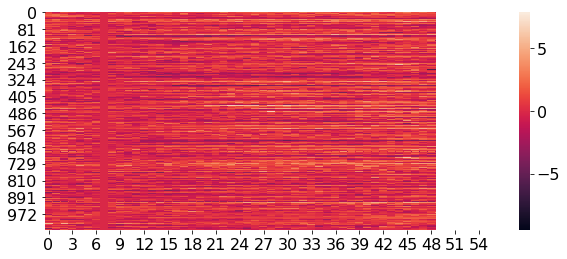

In [11]:
plt.figure(1,figsize=(10,4))
sns.heatmap(tcs_run_z[:,0,:,0])
tcs_run_z[0,0,:,0]

In [13]:
m = 2

in


<AxesSubplot:>

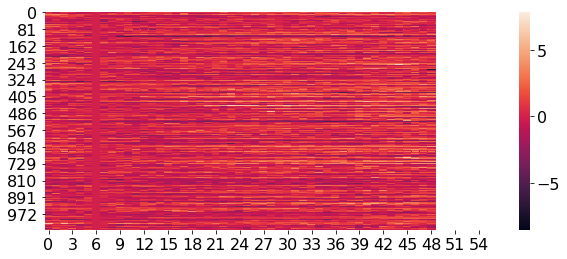

In [14]:
if tr_compensate==1:
    if len(np.where(tcs_run_z[:,0,vid_start_rel_tr[m]+1,m]==0)[0]) == tcs_run_z.shape[0]:
        print('in')
        for s in range(tcs_run_z.shape[0]):
            for n in range(tcs_run_z.shape[1]):
                for m in range(10):
                    tcs_run_z[s,n,:,m]  = tcs_run_z[s,n,:,m] - tcs_run_z[s,n,vid_start_rel_tr[m],m]
plt.figure(1,figsize=(10,4))
sns.heatmap(tcs_run_z[:,0,:,0])

In [17]:
# first of all, best to remove subjects with < 10 responses for power in general (and to keep consistent with beh results on all movies)
count_resp = np.zeros((responses.shape[0],))
for i in range(responses.shape[0]):
    count_resp[i] = len(np.where(~np.isnan(responses[i,:]))[0]) # nr. of responses per sub
#subs_10resp = np.where(count_resp == 10)[0]
subs_10resp = count_resp == 10
nsubs = len(np.where(subs_10resp)[0])
len(np.where(subs_10resp)[0])

subs_10resp_subs = np.where(subs_10resp)[0]
subs_10resp_subs.shape,subs_10resp.shape
nsubs = np.where(subs_10resp_subs)[0].shape[0]
nsubs

tr_compensate

1

In [19]:
z_score = 1 # change to 1 to get z-scored values

# load low-level properties timecourses
if z_score==1:
    brightness_reg_1 = np.load('brightness_reg_all_z.npy')
    of_reg_1 = np.load('optic_flow_reg_all_z.npy')
else:
    brightness_reg_1 = np.load('brightness_reg_all.npy')
    of_reg_1 = np.load('optic_flow_reg_all.npy')

#brightness_reg_1 -= brightness_reg_1[tr0_ind]
#of_reg_1 -= of_reg_1[tr0_ind]

# GET EVERYTHING COMPARABLE TO 3_2_1!!!

(31, 10)


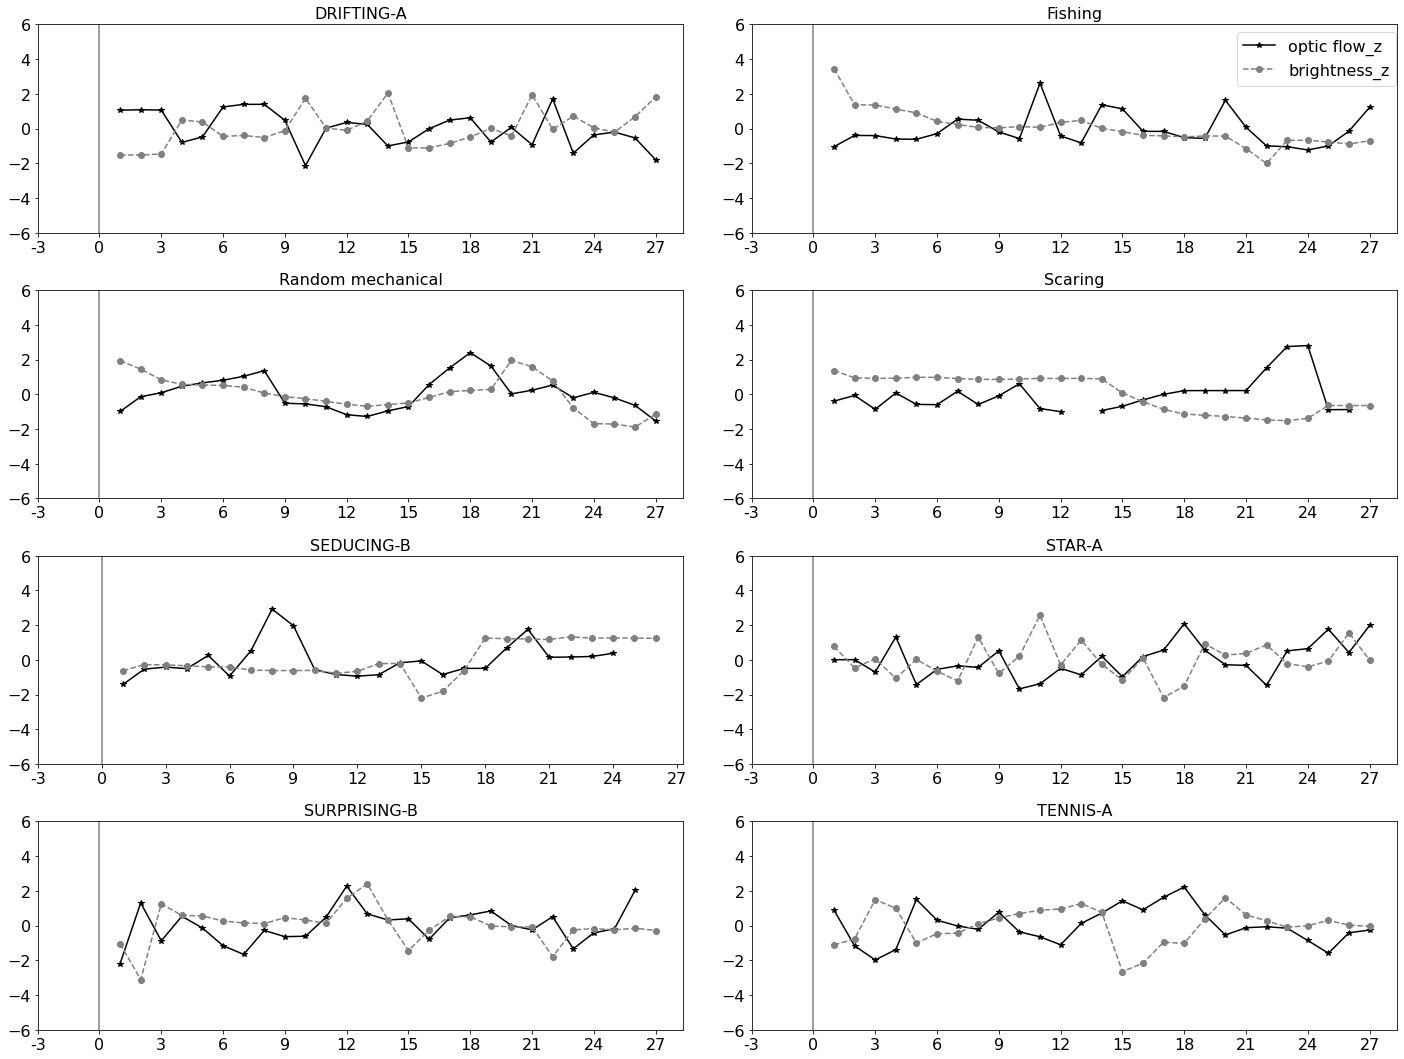

In [22]:
# if the first fmri TR is BEFORE t=0, push low-level regs to a later TR
if tr_compensate==1:
    of_reg, brightness_reg = [np.empty((31,10)) for _ in range(2)]
    of_reg[:], brightness_reg[:] = [np.nan]*2
    of_reg[1:,:] = of_reg_1[:-1,:]
    brightness_reg[1:,:] = brightness_reg_1[:-1,:]
else:
    of_reg,brightness_reg = of_reg_1,brightness_reg_1

print(of_reg.shape)

plt.figure(1,figsize=(20,15))
for i,m in enumerate(np.arange(2,10)):
    plt.subplot(4,2,i+1)
    plt.ylim(-6,6)
    plt.plot(of_reg[:,m],color='k',label='optic flow_z',marker = '*')
    plt.plot(brightness_reg[:,m],color='grey',ls='dashed', label='brightness_z',marker='o')
    plt.vlines(tr0_ind,plt.ylim()[0],plt.ylim()[1],color='grey')
    plt.title(vidnames[m])
    xticks = np.arange(0,32,3)
    plt.xticks(xticks,[str(i-tr0_ind) for i in xticks])
    if i==1:
        plt.legend(bbox_to_anchor=[1.01,1])

plt.tight_layout()

In [24]:
of_reg_1[:,2],of_reg[:,2],brightness_reg_1[:,2],brightness_reg[:,2]

(array([        nan,         nan,         nan,  1.05614645,  1.08414789,
         1.06355104, -0.7955141 , -0.48056414,  1.24448181,  1.39451889,
         1.39415348,  0.47493698, -2.13167998,  0.02565264,  0.35456523,
         0.24049527, -1.00046619, -0.76893974, -0.0110457 ,  0.4880956 ,
         0.62170334, -0.77411802,  0.07349727, -0.93442008,  1.70697586,
        -1.41751245, -0.36553516, -0.20414621, -0.53915536, -1.79982461,
                nan]),
 array([        nan,         nan,         nan,         nan,  1.05614645,
         1.08414789,  1.06355104, -0.7955141 , -0.48056414,  1.24448181,
         1.39451889,  1.39415348,  0.47493698, -2.13167998,  0.02565264,
         0.35456523,  0.24049527, -1.00046619, -0.76893974, -0.0110457 ,
         0.4880956 ,  0.62170334, -0.77411802,  0.07349727, -0.93442008,
         1.70697586, -1.41751245, -0.36553516, -0.20414621, -0.53915536,
        -1.79982461]),
 array([        nan,         nan,         nan, -1.51947903, -1.52423835,
     

In [26]:
for m in range(10):
    print(np.where(np.isnan(of_reg[:,m]))[0])

[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
[ 0  1  2  3 16 30]
[ 0  1  2  3 28 29 30]
[0 1 2 3]
[ 0  1  2  3 30]
[0 1 2 3]


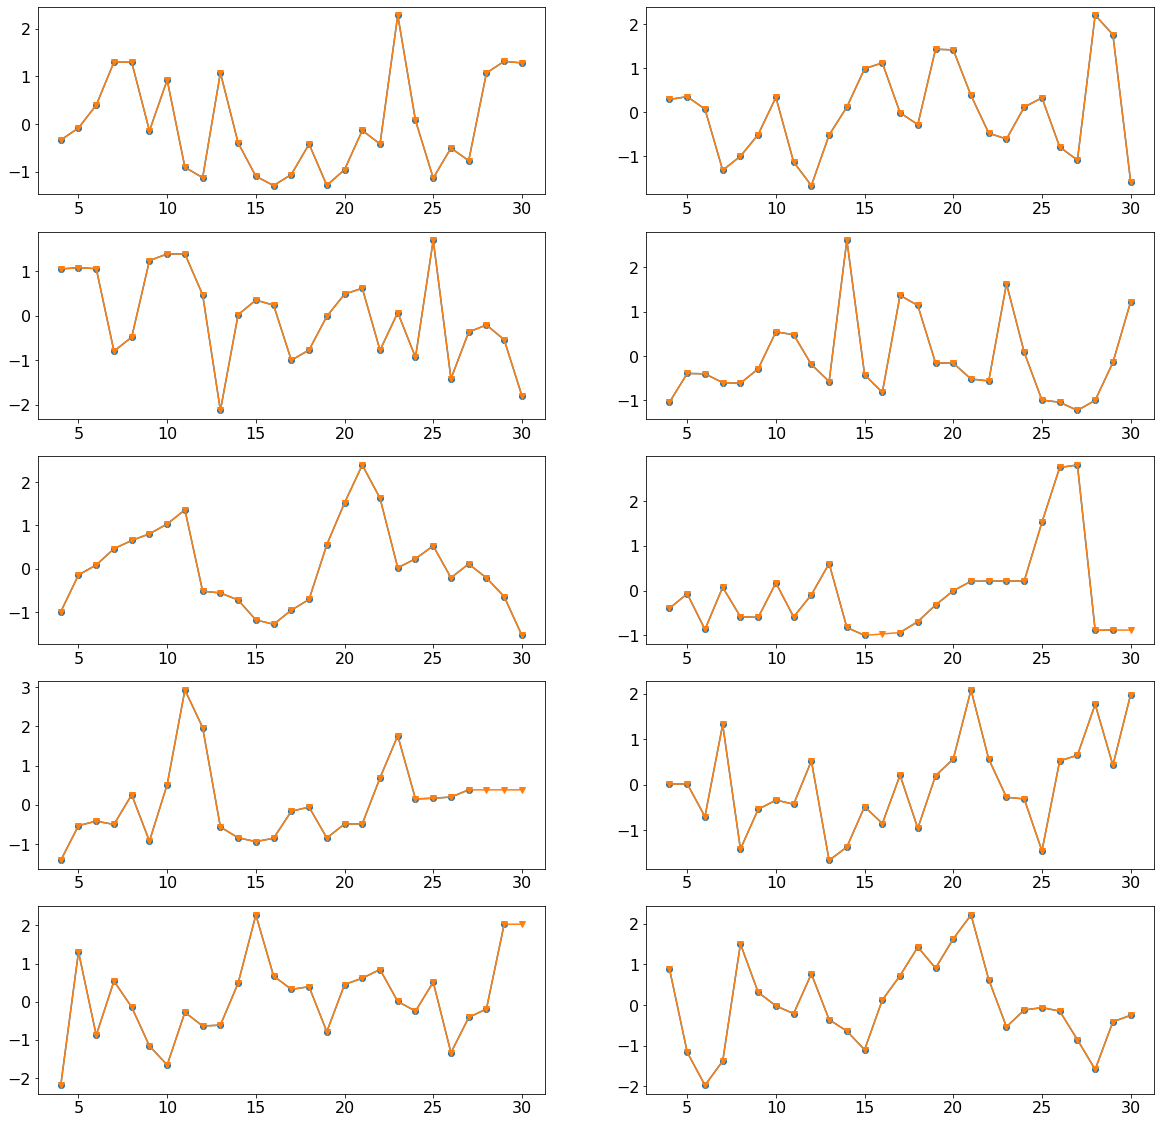

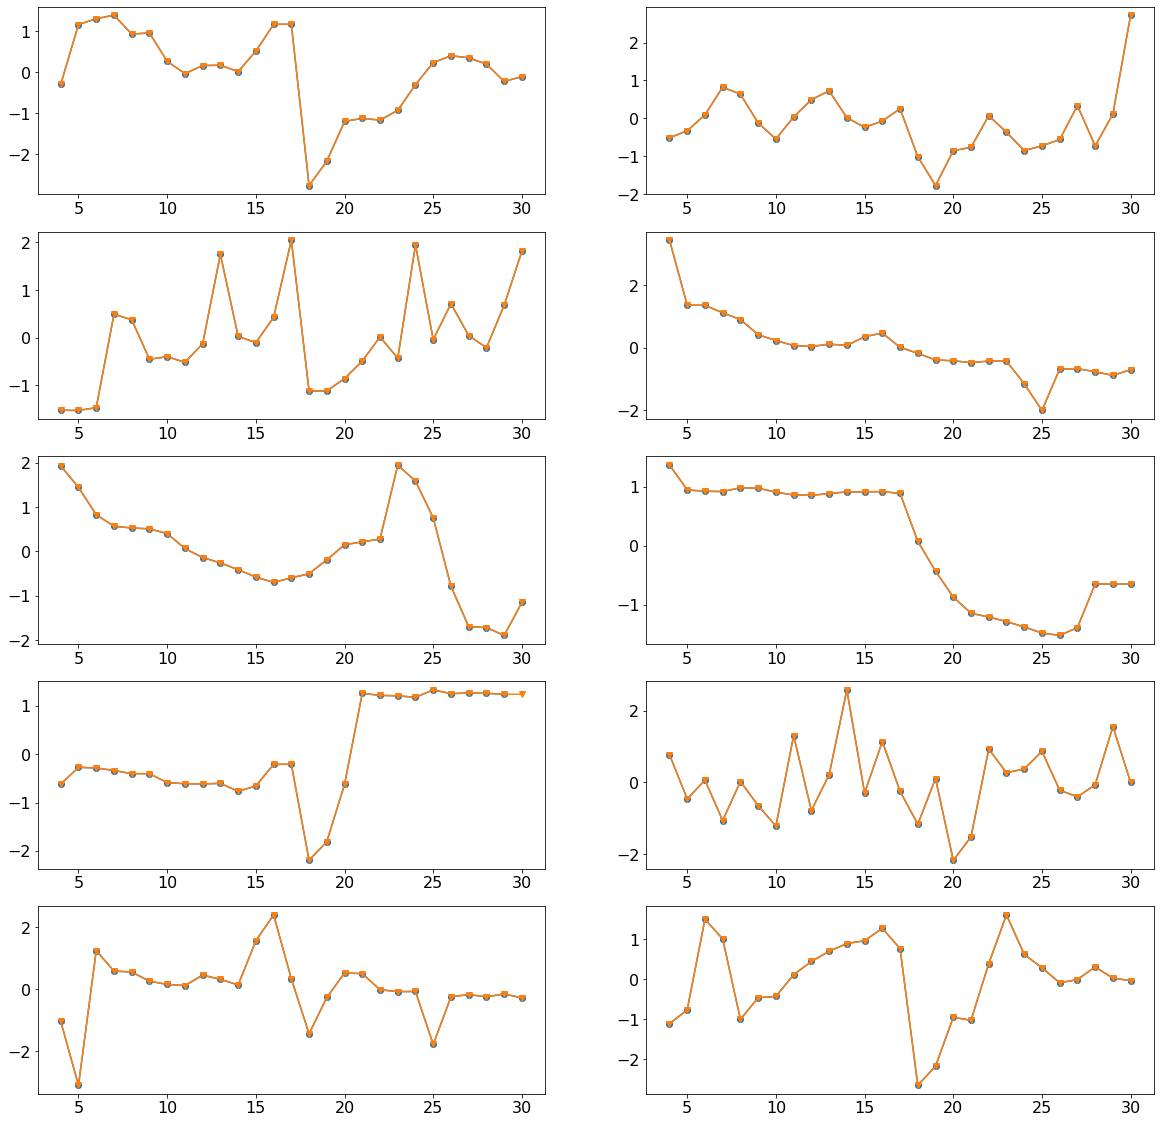

In [27]:
# fill in NaNs
plt.figure(1,figsize=(20,20))
for m in range(10):
    plt.subplot(5,2,m+1)
    plt.plot(of_reg[:,m],marker='o')
    of_nan = np.where(np.isnan(of_reg[:,m]))[0]
    #print('Movie ',m, ',before:',of_reg[:,m], '\n, nan:',of_nan)

    for nan in of_nan:
        if (nan > tr0_ind) and (nan < (of_reg.shape[0]-1)):
            of_reg[nan,m] = np.nanmean([of_reg[nan-1,m],of_reg[nan+1,m]])
        elif nan == (of_reg.shape[0]-1):
            of_reg[nan,m] = of_reg[nan-1,m]
    plt.plot(of_reg[:,m],marker = 'v')
    #print('After:',of_reg[:,m])

plt.figure(2,figsize=(20,20))
for m in range(10):
    plt.subplot(5,2,m+1)
    plt.plot(brightness_reg[:,m],marker='o')
    of_nan = np.where(np.isnan(brightness_reg[:,m]))[0]
    #print('Movie ',m, ',before:',brightness_reg[:,m], '\n, nan:',of_nan)

    for nan in of_nan:
        if (nan > tr0_ind) and (nan < (of_reg.shape[0]-1)):
            brightness_reg[nan,m] = np.nanmean([brightness_reg[nan-1,m],brightness_reg[nan+1,m]])
        elif nan == (of_reg.shape[0]-1):
            brightness_reg[nan,m] = brightness_reg[nan-1,m]
    plt.plot(brightness_reg[:,m],marker = 'v')
    #print('After:',of_reg[:,m])

In [30]:
import time
from joblib import cpu_count
from pymer4.models import Lmer,Lm
from multiprocessing import Pool
from sklearn.linear_model import LinearRegression
from joblib import Parallel,delayed

Text(0.5, 0, 'Time')

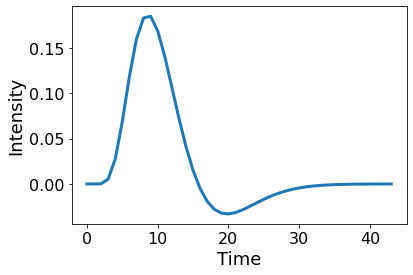

In [31]:
#defining the hrf
from nltools.external import glover_hrf

tr = .72
#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

In [32]:
def return_residuals(df,plotfig =0):
    # df: rows: ranging from tr-14 or the earliest TR to TR+28+14, columns: 0: BOLD, 1: optic flow, 2: brightness
    # plotfig: 1(plot) or 0(don't plot)
    # returns: residuals of the same dimension as nr of rows in df
    
    rows = ~(np.isnan(df[:,0])) & ~(np.isnan(df[:,1])) & ~(np.isnan(df[:,2]))
    total_len = df.shape[0]
    if len(np.where(rows)[0]) != total_len: # if NaN is present
        df_nonan = df[rows,:]
        y,regs = df_nonan[:,0],df_nonan[:,1:]
    else:
        y,regs = df[:,0],df[:,1:]
    
    #for i in range(2):
    #    regs[:,i] =  np.convolve(regs[:,i], hrf)[:regs.shape[0]]
    
    model = LinearRegression().fit(regs, y)
    #model = LinearRegression().fit(df_nonan[:,1:], df_nonan[:,0])
    resid = y - model.predict(regs)
 
    if plotfig:
        plt.plot(df[:,0],label='raw TC')
        plt.plot(df[:,1],label='optflow',color='grey')
        plt.plot(df[:,2],label='brightness',color='grey',ls='dashed')
        plt.plot(resid,label = 'residual TC1')
        plt.legend(bbox_to_anchor=[1.01,1])
    #print(resid1-resid)
    return resid

In [37]:
of_reg[:,2]

array([        nan,         nan,         nan,         nan,  1.05614645,
        1.08414789,  1.06355104, -0.7955141 , -0.48056414,  1.24448181,
        1.39451889,  1.39415348,  0.47493698, -2.13167998,  0.02565264,
        0.35456523,  0.24049527, -1.00046619, -0.76893974, -0.0110457 ,
        0.4880956 ,  0.62170334, -0.77411802,  0.07349727, -0.93442008,
        1.70697586, -1.41751245, -0.36553516, -0.20414621, -0.53915536,
       -1.79982461])

In [38]:
# create convolved regressors for coax-bill
reg_all = []
for m in range(10):
    reg = np.zeros((len(timepts_indiv_movie[m]),2))
    inds = np.arange(vid_start_rel_tr[m]+1,vid_start_rel_tr[m]+l_task)
    for ireg in range(2): 
        if ireg==0:
            reg[inds,0] = of_reg[tr0_ind+1:,m] #np.linspace(.01,1,len(inds))
        else:
            reg[inds,1] = brightness_reg[tr0_ind+1:,m] #np.linspace(.01,1,len(inds))
        reg[:,ireg] = np.convolve(reg[:,ireg], hrf)[:reg.shape[0]]

    reg_all.append(reg)
reg_all[2].shape

(56, 2)

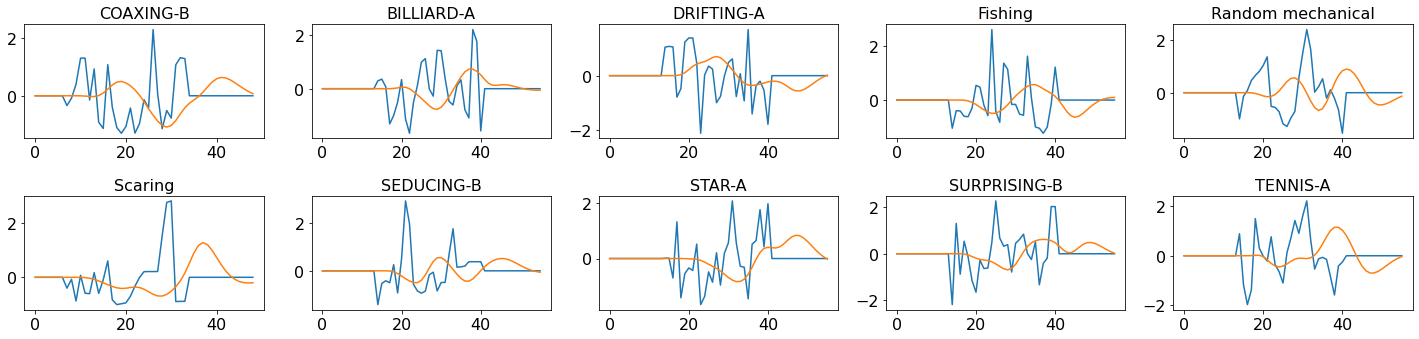

In [39]:
# visualize HRF
plt.figure(1,figsize=(20,5))
for m in range(10):
    reg = np.zeros((len(timepts_indiv_movie[m]),2))
    inds = np.arange(vid_start_rel_tr[m]+1,vid_start_rel_tr[m]+l_task)
    for ireg in range(2): 
        if ireg==0:
            reg[inds,0] = of_reg[tr0_ind+1:,m] #np.linspace(.01,1,len(inds))
        else:
            reg[inds,1] = brightness_reg[tr0_ind+1:,m] #np.linspace(.01,1,len(inds))

    plt.subplot(2,5,m+1)
    plt.plot(reg[:,0])
    plt.plot(reg_all[m][:,0])
    plt.title(vidnames[m])

plt.tight_layout()

In [40]:
tr_compensate

1

In [41]:
load_resid = 0 # 1: load residuals, 0: compute residuals for all subs because this can be useful for plotting random mech timecourses too
if load_resid == 0:
    resid_tc_run = np.empty((tcs_run_z.shape[0],268,31,10)) #subs, nodes, timepts, movies
    resid_tc_run[:] = np.nan
    start_time = time.time()
    parallelise = 1
    for s in np.arange(tcs_run_z.shape[0]):
        if (s%10 == 0) and (s!=0):
            print(s, f'time elapsed: {(time.time()-start_time)/60:.2f}')

        for m in np.arange(10):
            df = []
            for n in range(268):
                if  m%5 == 0:
                    y = tcs_run_z[s,n,:49,m]
                else:
                    y = tcs_run_z[s,n,:,m]
                df.append(np.array([y,reg_all[m][:,0],reg_all[m][:,1]]).T)

            if parallelise:
                residuals_ = Parallel(n_jobs=10)(delayed(return_residuals)(y) for y in df)  # pool.map(return_residuals,df_coax) 
                #resid_tc[i,:,tr0_ind:,0],resid_tc[i,:,tr0_ind:,1] = np.array(residuals_coax), np.array(residuals_bill)
                
            else:
                residuals_ = []
                for n in range(268):
                    residuals_.append(return_residuals(df[n]))   
            
            tmin,tmax = vid_start_rel_tr[m]-tr0_ind,vid_start_rel_tr[m]+28
            for n in range(268):
                res_n = residuals_[n][tmin:tmax]
                res_n -= res_n[tr0_ind]
                resid_tc_run[s,n,:,m] = res_n
                
    if tr_compensate==1:
        np.save(os.path.join(data_file_loc,'residuals_tc_z_runwise_earlyTR.npy'),resid_tc_run)
    else:
        np.save(os.path.join(data_file_loc,'residuals_tc_z_runwise_lateTR.npy'),resid_tc_run)
    #else:
    #   np.save(os.path.join(data_file_loc,'residuals_tc_run.npy'),resid_tc_run)
else:
    #if z_score==1:
    if tr_compensate==1:
        resid_tc_run = np.load(os.path.join(data_file_loc,'residuals_tc_z_runwise_earlyTR.npy'))
    else:
        resid_tc_run = np.load(os.path.join(data_file_loc,'residuals_tc_z_runwise_lateTR.npy'))
    #else:
    #    resid_tc_run = np.load(os.path.join(data_file_loc,'residuals_tc_run.npy'))

10 time elapsed: 0.53
20 time elapsed: 1.02
30 time elapsed: 1.50
40 time elapsed: 1.98
50 time elapsed: 2.44


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


60 time elapsed: 141.63
70 time elapsed: 142.15
80 time elapsed: 142.63
90 time elapsed: 143.09
100 time elapsed: 143.55
110 time elapsed: 144.01
120 time elapsed: 144.47
130 time elapsed: 144.92
140 time elapsed: 145.40
150 time elapsed: 145.87
160 time elapsed: 146.34
170 time elapsed: 146.83
180 time elapsed: 147.30
190 time elapsed: 147.78
200 time elapsed: 148.24
210 time elapsed: 148.73
220 time elapsed: 149.27
230 time elapsed: 149.76
240 time elapsed: 150.22
250 time elapsed: 150.67
260 time elapsed: 151.18
270 time elapsed: 151.70
280 time elapsed: 152.19
290 time elapsed: 152.66
300 time elapsed: 153.18
310 time elapsed: 153.65
320 time elapsed: 154.12
330 time elapsed: 154.60
340 time elapsed: 155.07
350 time elapsed: 155.54
360 time elapsed: 156.02
370 time elapsed: 156.56
380 time elapsed: 157.09
390 time elapsed: 157.57
400 time elapsed: 158.10
410 time elapsed: 158.60
420 time elapsed: 159.08
430 time elapsed: 159.54
440 time elapsed: 159.99
450 time elapsed: 160.44
460 

<AxesSubplot:>

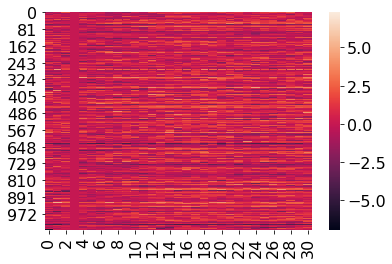

In [42]:
sns.heatmap(resid_tc_run[:,0,:,2])

In [43]:
# collapse across movies and runs (for timecourse plots)
other_movies = [2,3,4,5,6,7,8,9] #mmin,mmax = 2,10
tcs_run_resh_yes_nocoaxbill = []
tcs_run_resh_no_nocoaxbill  = []
residuals_run_resh_yes_nocoaxbill = []
residuals_run_resh_no_nocoaxbill = []
subs_resh_yes_nocoaxbill    = []
subs_resh_no_nocoaxbill     = []
for m in other_movies:
    rows1 = subs_10resp & (responses[:,m]==1)
    rows2 = subs_10resp & (responses[:,m]==0)
    tcs_run_resh_yes_nocoaxbill.append(tcs_run_z[rows1,:,:,m]) # subsm * 268 * 31
    tcs_run_resh_no_nocoaxbill.append( tcs_run_z[rows2,:,:,m]) # subsm * 268 * 31
    residuals_run_resh_yes_nocoaxbill.append(resid_tc_run[rows1,:,:,m]) # subsm * 268 * 31
    residuals_run_resh_no_nocoaxbill.append(resid_tc_run[rows2,:,:,m]) # subsm * 268 * 31
    subs_resh_yes_nocoaxbill += list(np.where(rows1)[0])       # subsm * 268 * 31, keep track of subject seq
    subs_resh_no_nocoaxbill  += list(np.where(rows2)[0])       # subsm * 268 * 31

tcs_run_resh_yes_nocoaxbill = np.concatenate(tcs_run_resh_yes_nocoaxbill,axis=0)
tcs_run_resh_no_nocoaxbill  = np.concatenate(tcs_run_resh_no_nocoaxbill, axis=0)
residuals_run_resh_yes_nocoaxbill = np.concatenate(residuals_run_resh_yes_nocoaxbill,axis=0)
residuals_run_resh_no_nocoaxbill  = np.concatenate(residuals_run_resh_no_nocoaxbill, axis=0)
print('Across all movies except coax-bill: \nyes:'+ str(tcs_run_resh_yes_nocoaxbill.shape) + ',\nno:' + str(tcs_run_resh_no_nocoaxbill.shape))

Across all movies except coax-bill: 
yes:(3209, 268, 56),
no:(2849, 268, 56)


In [44]:
tmin,tmax = vid_start_rel_tr[2],vid_start_rel_tr[2]+28

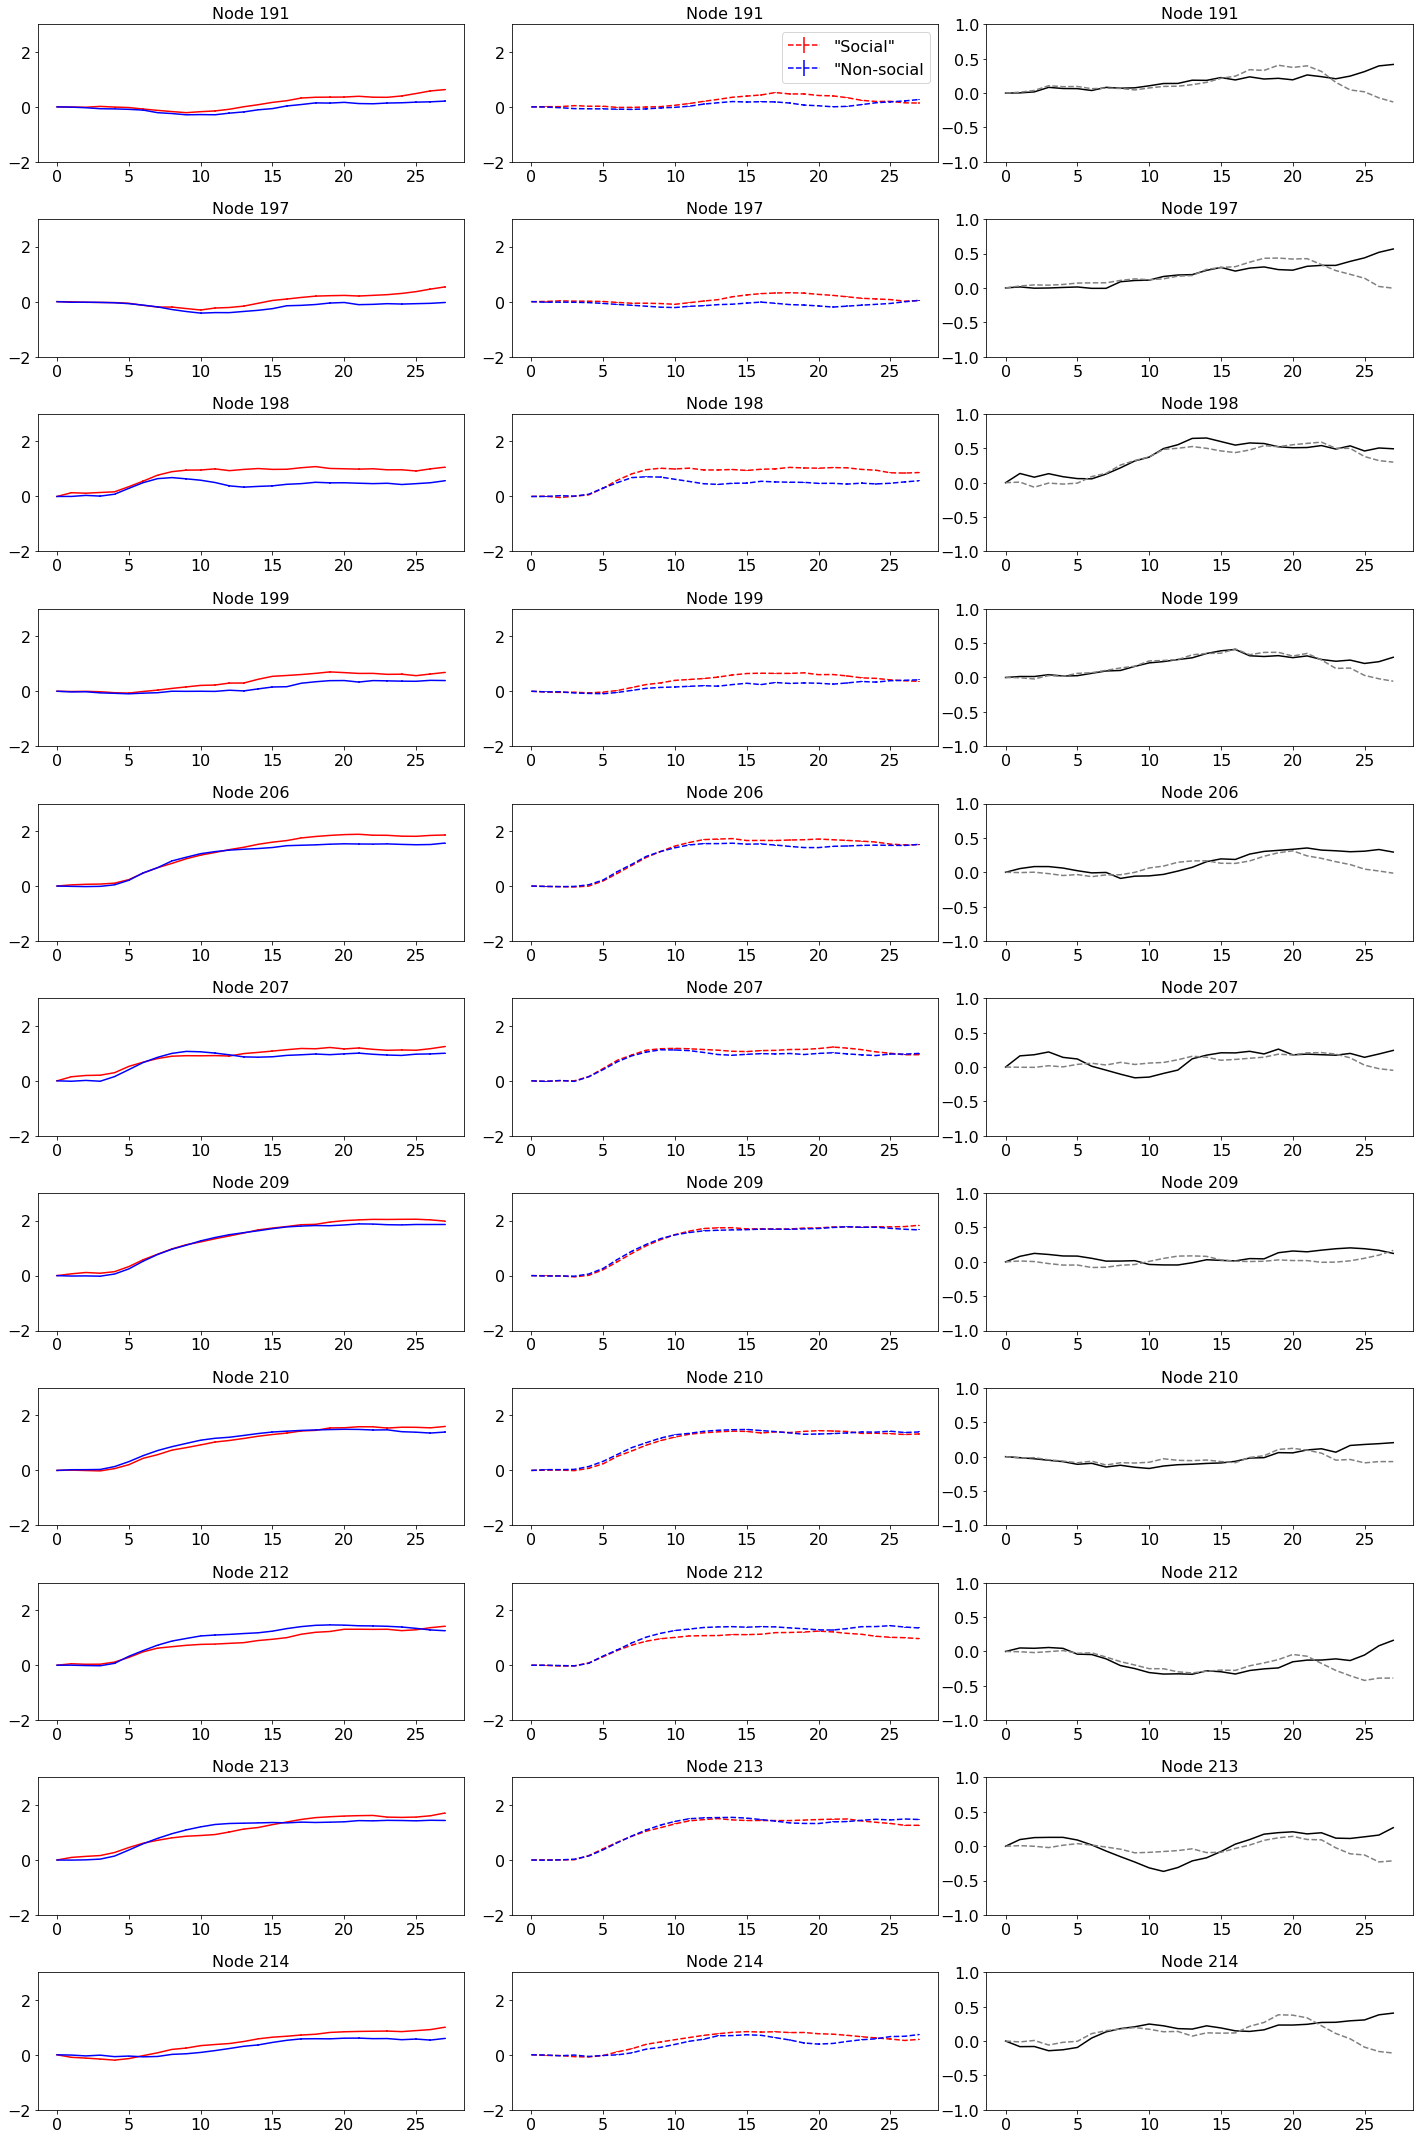

In [45]:
'''n = 65
plt.figure(1,figsize=(10,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    tc_res = resid_tc[:,n,tr0_ind:,i]
    tc = tcs_trial_z[subs,n,tr0_ind:,i]
    plt.errorbar(range(28),np.nanmean(tc,axis=0),stats.sem(tc,axis=0),color='k',label='mean data')
    plt.plot((brightness_reg[tr0_ind:,i])/(max(brightness_reg[tr0_ind:,i])-min(brightness_reg[tr0_ind:,i])))
    plt.plot((of_reg[tr0_ind:,i])/(max(of_reg[tr0_ind:,i])-min(of_reg[tr0_ind:,i])))
    plt.errorbar(range(28),np.nanmean(tc_res,axis=0),stats.sem(tc_res,axis=0),color='k',ls='dashed',label = 'mean resid')
    plt.legend()
    plt.title(vidnames[i])'''

col = ['r','b']
plt.figure(1,figsize=(20,30))
ncols = 3
for i,n in enumerate([190,196,197,198,205,206,208,209,211,212,213]):#df_minus10_0_right['Nodes'].values):
    #n = 65
    plt.subplot(11,ncols,i*ncols+1)
    
    plt.title('Node ' + str(n+1))
    #for m in np.arange(2,10):
    tc = tcs_run_resh_yes_nocoaxbill[:,n,tmin:tmax]
    plt.errorbar(range(28),np.nanmedian(tc,axis=0),stats.sem(tc,axis=0),color=col[0],label=vidnames[m])
    tc = tcs_run_resh_no_nocoaxbill[:,n,tmin:tmax]
    plt.errorbar(range(28),np.nanmedian(tc,axis=0),stats.sem(tc,axis=0),color=col[1],label=vidnames[m])
    #plt.plot((brightness_reg[tr0_ind:,i])/(max(brightness_reg[tr0_ind:,i])-min(brightness_reg[tr0_ind:,i])))
    #plt.plot((of_reg[tr0_ind:,i])/(max(of_reg[tr0_ind:,i])-min(of_reg[tr0_ind:,i])))
    plt.ylim(-2,3)

    plt.subplot(11,ncols,i*ncols+2)
    plt.title('Node ' + str(n+1))
    #for m in range(2):
    tc_res = residuals_run_resh_yes_nocoaxbill[:,n,tr0_ind:]
    plt.errorbar(range(28),np.nanmedian(tc_res,axis=0),stats.sem(tc_res,axis=0),color=col[0],ls='dashed',label = '"Social"')
    tc_res = residuals_run_resh_no_nocoaxbill[:,n,tr0_ind:]
    plt.errorbar(range(28),np.nanmedian(tc_res,axis=0),stats.sem(tc_res,axis=0),color=col[1],ls='dashed',label = '"Non-social')
        
    if i==0:
        plt.legend()#bbox_to_anchor=[1.01,1])
    plt.ylim(-2,3)

    plt.subplot(11,ncols,i*ncols+3)
    plt.title('Node ' + str(n+1))
    tc_diff = np.nanmedian(tcs_run_resh_yes_nocoaxbill[:,n,tmin:tmax],axis=0) - np.nanmedian(tcs_run_resh_no_nocoaxbill[:,n,tmin:tmax],axis=0)
    plt.plot(range(28),tc_diff,color='k',label=f'{vidnames[1]}-\n{vidnames[0]}')
    plt.ylim(-1,1)

    #plt.subplot(11,ncols,i*ncols+3)
    plt.title('Node ' + str(n+1))
    resid_diff = np.nanmedian(residuals_run_resh_yes_nocoaxbill[:,n,tr0_ind:],axis=0) - np.nanmedian(residuals_run_resh_no_nocoaxbill[:,n,tr0_ind:],axis=0)
    plt.plot(range(28),resid_diff,color='grey',ls='--')#,label=f'{vidnames[1]}-\n{vidnames[0]}')
    #plt.legend()
    plt.ylim(-1,1)
    
plt.tight_layout()

# not soted early to late.

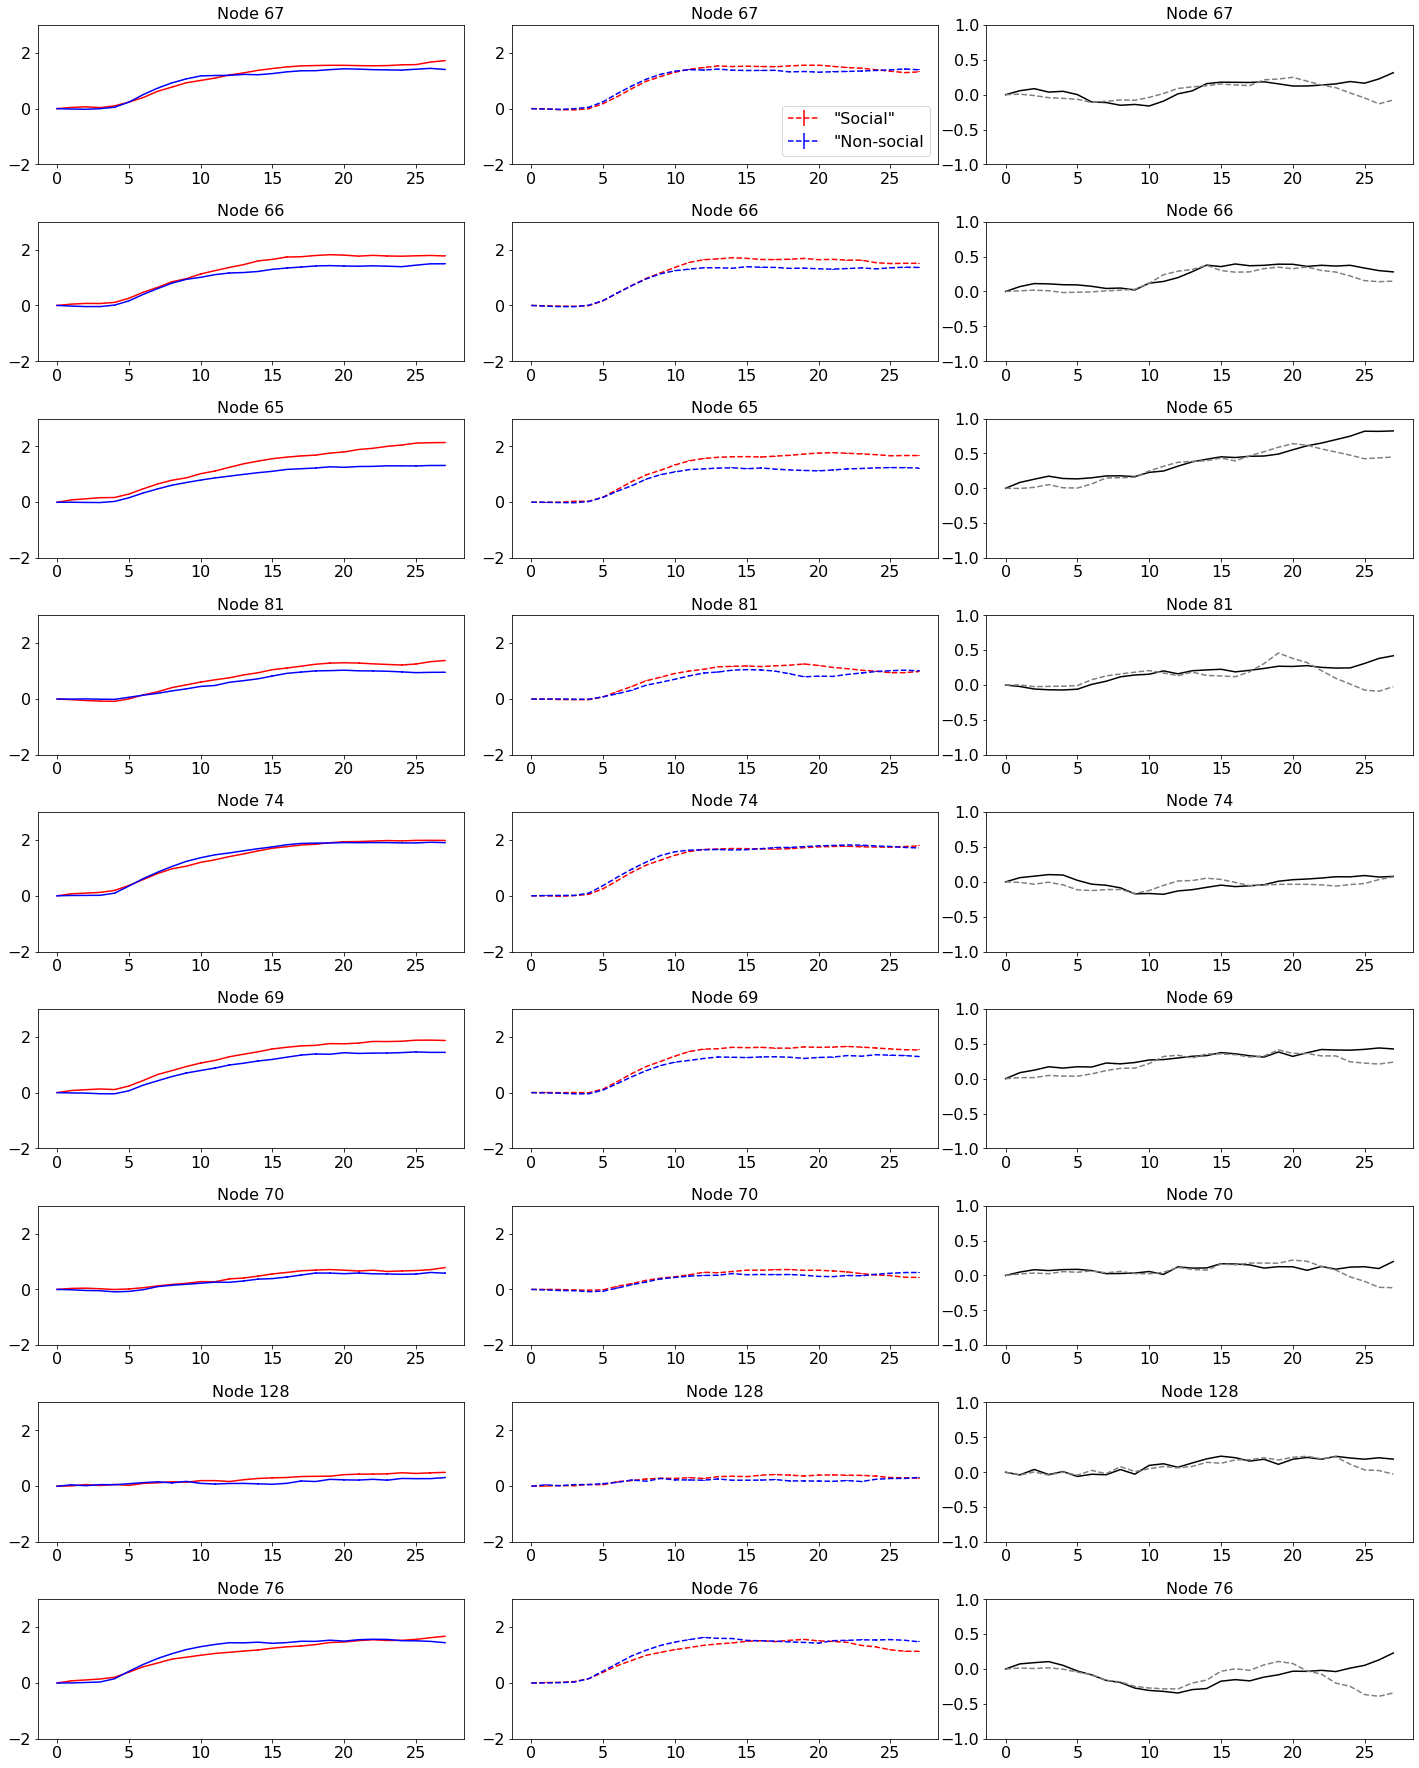

In [47]:
'''n = 65
plt.figure(1,figsize=(10,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    tc_res = resid_tc[:,n,tr0_ind:,i]
    tc = tcs_trial_z[subs,n,tr0_ind:,i]
    plt.errorbar(range(28),np.nanmean(tc,axis=0),stats.sem(tc,axis=0),color='k',label='mean data')
    plt.plot((brightness_reg[tr0_ind:,i])/(max(brightness_reg[tr0_ind:,i])-min(brightness_reg[tr0_ind:,i])))
    plt.plot((of_reg[tr0_ind:,i])/(max(of_reg[tr0_ind:,i])-min(of_reg[tr0_ind:,i])))
    plt.errorbar(range(28),np.nanmean(tc_res,axis=0),stats.sem(tc_res,axis=0),color='k',ls='dashed',label = 'mean resid')
    plt.legend()
    plt.title(vidnames[i])'''

col = ['r','b']
plt.figure(1,figsize=(20,30))
ncols = 3
for i,n in enumerate([66,65,64,80,73,68,69,127,75]):#df_minus10_0_right['Nodes'].values):
    #n = 65
    plt.subplot(11,ncols,i*ncols+1)
    
    plt.title('Node ' + str(n+1))
    #for m in np.arange(2,10):
    tc = tcs_run_resh_yes_nocoaxbill[:,n,tmin:tmax]
    plt.errorbar(range(28),np.nanmedian(tc,axis=0),stats.sem(tc,axis=0),color=col[0],label=vidnames[m])
    tc = tcs_run_resh_no_nocoaxbill[:,n,tmin:tmax]
    plt.errorbar(range(28),np.nanmedian(tc,axis=0),stats.sem(tc,axis=0),color=col[1],label=vidnames[m])
    #plt.plot((brightness_reg[tr0_ind:,i])/(max(brightness_reg[tr0_ind:,i])-min(brightness_reg[tr0_ind:,i])))
    #plt.plot((of_reg[tr0_ind:,i])/(max(of_reg[tr0_ind:,i])-min(of_reg[tr0_ind:,i])))
    plt.ylim(-2,3)

    plt.subplot(11,ncols,i*ncols+2)
    plt.title('Node ' + str(n+1))
    #for m in range(2):
    tc_res = residuals_run_resh_yes_nocoaxbill[:,n,tr0_ind:]
    plt.errorbar(range(28),np.nanmedian(tc_res,axis=0),stats.sem(tc_res,axis=0),color=col[0],ls='dashed',label = '"Social"')
    tc_res = residuals_run_resh_no_nocoaxbill[:,n,tr0_ind:]
    plt.errorbar(range(28),np.nanmedian(tc_res,axis=0),stats.sem(tc_res,axis=0),color=col[1],ls='dashed',label = '"Non-social')
        
    if i==0:
        plt.legend()#bbox_to_anchor=[1.01,1])
    plt.ylim(-2,3)

    plt.subplot(11,ncols,i*ncols+3)
    plt.title('Node ' + str(n+1))
    tc_diff = np.nanmedian(tcs_run_resh_yes_nocoaxbill[:,n,tmin:tmax],axis=0) - np.nanmedian(tcs_run_resh_no_nocoaxbill[:,n,tmin:tmax],axis=0)
    plt.plot(range(28),tc_diff,color='k',label=f'{vidnames[1]}-\n{vidnames[0]}')
    plt.ylim(-1,1)

    #plt.subplot(11,ncols,i*ncols+3)
    plt.title('Node ' + str(n+1))
    resid_diff = np.nanmedian(residuals_run_resh_yes_nocoaxbill[:,n,tr0_ind:],axis=0) - np.nanmedian(residuals_run_resh_no_nocoaxbill[:,n,tr0_ind:],axis=0)
    plt.plot(range(28),resid_diff,color='grey',ls='--')#,label=f'{vidnames[1]}-\n{vidnames[0]}')
    #plt.legend()
    plt.ylim(-1,1)
    
plt.tight_layout()

# not soted early to late.

<AxesSubplot:>

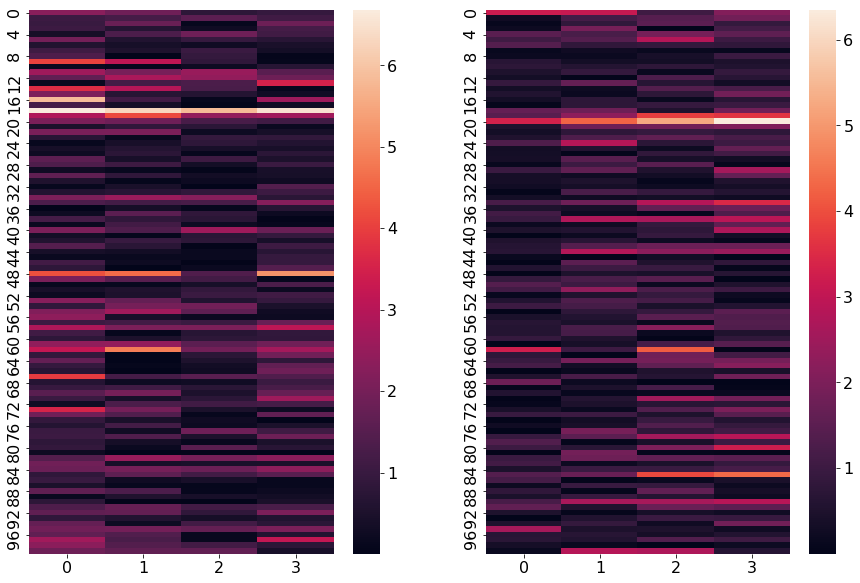

In [81]:
plt.figure(1,figsize=(15,10))
plt.subplot(121)
sns.heatmap(np.abs(tcs_run_z[subs_10resp_subs[:100],213,tr0_ind+1:tr0_ind+5,0] - tcs_run_z[subs_10resp_subs[:100],213,tr0_ind+1:tr0_ind+5,1]))

plt.subplot(122)
sns.heatmap(np.abs(resid_tc_run[:100,213,tr0_ind+1:tr0_ind+5,0] - resid_tc_run[:100,213,tr0_ind+1:tr0_ind+5,1]))

In [66]:
print(np.abs(tcs_run_z[subs_10resp_subs[:100],213,tr0_ind+1:tr0_ind+5,0] - tcs_run_z[subs_10resp_subs[:100],213,tr0_ind+1:tr0_ind+5,1])[:10,0])
print(np.abs(resid_tc_run[:100,213,tr0_ind+1:tr0_ind+5,0] - resid_tc_run[:100,213,tr0_ind+1:tr0_ind+5,1])[:10,0])

[0.88725688 0.72714637 2.13813265 0.2330736  0.3500176  0.58739369
 0.41225381 0.38586662 0.35806558 0.15019479]
[0.44516535 0.67584181 2.25486323 0.10243217 0.10473371 0.36479929
 0.09519205 0.15733829 0.2094729  0.45503386]
